- https://link.springer.com/chapter/10.1007/978-3-319-01796-9_7 (SIFT + SVM classifier)
-

In [1]:
import sys
print(sys.executable)


/usr/bin/python3


In [2]:
# %pip install numpy matplotlib pandas tqdm requests scikit-image scikit-learn imutils opencv-contrib-python pillow


In [3]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# preprocess & augmentation
import os
import cv2
import re
import string
from google.colab.patches import cv2_imshow
import pickle

# segmentation
from imutils.object_detection import non_max_suppression

# region proposal -> object detection
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer
# from google.colab.patches import cv2_imshow


In [4]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [5]:
print(tf.__version__)

2.19.0


### drive test

In [6]:
  # !pip uninstall opencv-python opencv-contrib-python opencv-python-headless
  # !pip install opencv-contrib-python
  # !pip install tf-models-official

In [7]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


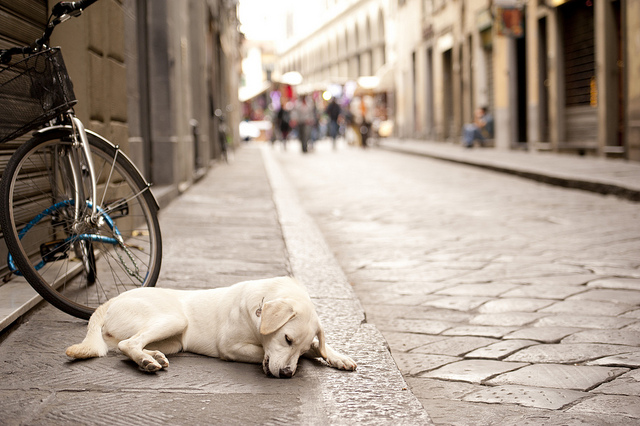

In [8]:
test_img = cv2.imread('/content/drive/MyDrive/KULIAH/SEM-5/caption-generation/dog-example.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(test_img)

# 1. Load COCO2017 - for collab

In [9]:
from zipfile import ZipFile
import requests
import json

# progress bar
from tqdm import tqdm
import shutil

In [10]:
# 1. buat directory
base_dir="./data/coco2017"

# struktur folder
os.makedirs(os.path.join(base_dir, "images", "train2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "val2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "annotations"), exist_ok=True)

print("Folder successfully created...")


Folder successfully created...


In [11]:
urls = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

download_dir = base_dir
subset_size= 50000

# download & extract
for name, url in urls.items():
  # print(name, url)
  zip_path = os.path.join(download_dir, f"{name}.zip")

  print(f"Donwload {name}...")
  response = requests.get(url, stream=True) #donwload bertahap(stream)
  with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
      # pastikan write tdk empty
      if chunk:
        f.write(chunk)
  print(f"Download & extract {zip_path}...")

  with ZipFile(zip_path, 'r') as zip_ref:
    if "train" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "train2017"))
    elif "val" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "val2017"))
    else:
      zip_ref.extractall(os.path.join(base_dir, "annotations"))
  print(f"Extracted {name}")

print("process donwload & extract done.")

Donwload train_images...
Download & extract ./data/coco2017/train_images.zip...
Extracted train_images
Donwload val_images...
Download & extract ./data/coco2017/val_images.zip...
Extracted val_images
Donwload annotations...
Download & extract ./data/coco2017/annotations.zip...
Extracted annotations
process donwload & extract done.


In [12]:
import json

annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(annotation_path, "r") as f:
    data = json.load(f)

print(data.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [13]:
# get instances subset (JSON) - take 50ribu
annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
subset_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017_subset.json")
subset_size=50000

if not os.path.exists(annotation_path):
  print(f"Error annot file not found = {annotation_path}")
else:
  with open(annotation_path, "r") as f:
    data=json.load(f)
  print(f"total annot asli : {len(data['annotations'])}")

  # subset
  subset_annot = data['annotations'][:subset_size]
  subset_category = data['categories']

  # ambil id gbr
  img_ids = set(ann["image_id"] for ann in subset_annot)
  subset_img_info = [img for img in data["images"] if img["id"] in img_ids]

  # simpan subset
  subset_data = {
      "info": data.get("info", {}),
      "licenses": data.get("licenses", []),
      "images": subset_img_info, # info image di subset
      "annotations": subset_annot,
      "categories": subset_category
  }

  os.makedirs(os.path.dirname(subset_path), exist_ok=True)
  with open(subset_path, "w") as f:
      json.dump(subset_data, f)

  print(f"Subset JSON dibuat: {subset_path}")
  print(f"tot img di subset info: {len(subset_img_info)} | Tot annotations: {len(subset_annot)}")

  # copy ke local source
  src_dir_option = os.path.join(base_dir, "images", "train2017", "train2017") # Common structure from zip

  src_dir = None
  if os.path.exists(src_dir_option) and len(os.listdir(src_dir_option)) > 0:
      src_dir = src_dir_option


  if src_dir:
      # destination directory
      dst_dir = os.path.join(base_dir, "images", "train2017_subset")
      os.makedirs(dst_dir, exist_ok=True)

      print(f"\nCopying subset image files from {src_dir} to {dst_dir}...")
      # Copy only file names present in the subset_images_info
      copied_count = 0
      # Create a set of file names to copy for faster lookup
      subset_image_filenames = {img_info["file_name"] for img_info in subset_img_info}

      # Iterate through files in the source directory and copy if they are in the subset
      for filename in tqdm(os.listdir(src_dir), desc="Checking & copying images"):
          if filename in subset_image_filenames:
                src_path = os.path.join(src_dir, filename)
                dst_path = os.path.join(dst_dir, filename)
                try:
                    shutil.copy(src_path, dst_path)
                    copied_count += 1
                except Exception as e:
                    print(f"Warning: Could not copy file {src_path} to {dst_path}: {e}")


      print(f"Finished copying. {copied_count} images copied to subset folder.")
      # Check if the number of copied files matches the number of images in the subset info
      if copied_count != len(subset_img_info):
          print(f"Warning: Number of copied files ({copied_count}) != subset info ({len(subset_img_info)}). Some source files might be missing.")

      print("Subset 50K image & annotations (locally copied images) ready")


total annot asli : 860001
Subset JSON dibuat: ./data/coco2017/annotations/annotations/instances_train2017_subset.json
tot img di subset info: 7920 | Tot annotations: 50000

Copying subset image files from ./data/coco2017/images/train2017/train2017 to ./data/coco2017/images/train2017_subset...


Checking & copying images: 100%|██████████| 118287/118287 [00:34<00:00, 3437.18it/s]

Finished copying. 7920 images copied to subset folder.
Subset 50K image & annotations (locally copied images) ready


In [14]:
def load_coco_detection_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f) # images, annotations bonding box, categories label

  # map img id -> filename
  images = {img['id']: img for img in ann['images']}

  # dict
  # pairs=[]
  grouped_pairs={}

  for item in ann['annotations']:
    img_id = item['image_id']
    # img_meta = images[item['image_id']]
    # img_path = os.path.join(img_dir, img_meta['file_name'])
    if img_id not in grouped_pairs:
      img_meta = images[img_id]
      img_path = os.path.join(img_dir, img_meta['file_name'])

      if os.path.exists(img_path):
        grouped_pairs[img_id]={
            "img": img_path,
            "boxes": [], #list boxes
            "labels": [] # list label
        }
      else:
        continue

    grouped_pairs[img_id]['boxes'].append(item['bbox'])
    grouped_pairs[img_id]['labels'].append(item['category_id'])

  pairs = list(grouped_pairs.values())
  return pairs

In [15]:
import json

path = "./data/coco2017/annotations/annotations/instances_val2017.json"
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(train_annot_path, "r") as f:
    data_train = json.load(f)

print(data_train.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [16]:
# 1. load coco pairs
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"
val_annot_path = "./data/coco2017/annotations/annotations/instances_val2017.json"

train_img_dir = "./data/coco2017/images/train2017_subset"
val_img_dir = "./data/coco2017/images/val2017/val2017"

train_pairs_detection = load_coco_detection_pairs(train_img_dir, train_annot_path)
val_pairs_detection = load_coco_detection_pairs(val_img_dir, val_annot_path)
print(train_pairs_detection[0])
print("Tot TRAIN detection pairs annot : ", len(train_pairs_detection))
print("Tot VAL detection pairsa annot : ", len(val_pairs_detection))

# cek kategori ada brp
with open(train_annot_path, 'r') as f:
    ann=json.load(f)
categories = ann.get("categories", [])
print("Total categories: ", len(categories))

print("\n Sample category: ")
for cat in categories[:5]:
  print(f"{cat["id"]} : {cat["name"]}")

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
Tot TRAIN detection pairs annot :  7920
Tot VAL detection pairsa annot :  4952
Total categories:  80

 Sample category: 
1 : person
2 : bicycle
3 : car
4 : motorcycle
5 : airplane


In [17]:
# distribusi per id
from collections import Counter

ann = data["annotations"]

category_counts = Counter([a["category_id"] for a in ann])

print("Total kategori subset : ", len(sorted(category_counts.items())))
for cid, count in sorted(category_counts.items()):
  print(f"Category {cid} : {count} sample")

Total kategori subset :  80
Category 1 : 262465 sample
Category 2 : 7113 sample
Category 3 : 43867 sample
Category 4 : 8725 sample
Category 5 : 5135 sample
Category 6 : 6069 sample
Category 7 : 4571 sample
Category 8 : 9973 sample
Category 9 : 10759 sample
Category 10 : 12884 sample
Category 11 : 1865 sample
Category 13 : 1983 sample
Category 14 : 1285 sample
Category 15 : 9838 sample
Category 16 : 10806 sample
Category 17 : 4768 sample
Category 18 : 5508 sample
Category 19 : 6587 sample
Category 20 : 9509 sample
Category 21 : 8147 sample
Category 22 : 5513 sample
Category 23 : 1294 sample
Category 24 : 5303 sample
Category 25 : 5131 sample
Category 27 : 8720 sample
Category 28 : 11431 sample
Category 31 : 12354 sample
Category 32 : 6496 sample
Category 33 : 6192 sample
Category 34 : 2682 sample
Category 35 : 6646 sample
Category 36 : 2685 sample
Category 37 : 6347 sample
Category 38 : 9076 sample
Category 39 : 3276 sample
Category 40 : 3747 sample
Category 41 : 5543 sample
Category 42

1 (person): 262465 samples
2 (bicycle): 7113 samples
3 (car): 43867 samples
4 (motorcycle): 8725 samples
5 (airplane): 5135 samples
6 (bus): 6069 samples
7 (train): 4571 samples
8 (truck): 9973 samples
9 (boat): 10759 samples
10 (traffic light): 12884 samples
11 (fire hydrant): 1865 samples
13 (stop sign): 1983 samples
14 (parking meter): 1285 samples
15 (bench): 9838 samples
16 (bird): 10806 samples
17 (cat): 4768 samples
18 (dog): 5508 samples
19 (horse): 6587 samples
20 (sheep): 9509 samples
21 (cow): 8147 samples
22 (elephant): 5513 samples
23 (bear): 1294 samples
24 (zebra): 5303 samples
25 (giraffe): 5131 samples
27 (backpack): 8720 samples
28 (umbrella): 11431 samples
31 (handbag): 12354 samples
32 (tie): 6496 samples
33 (suitcase): 6192 samples
34 (frisbee): 2682 samples
35 (skis): 6646 samples
36 (snowboard): 2685 samples
37 (sports ball): 6347 samples
38 (kite): 9076 samples
39 (baseball bat): 3276 samples
40 (baseball glove): 3747 samples
41 (skateboard): 5543 samples
42 (su

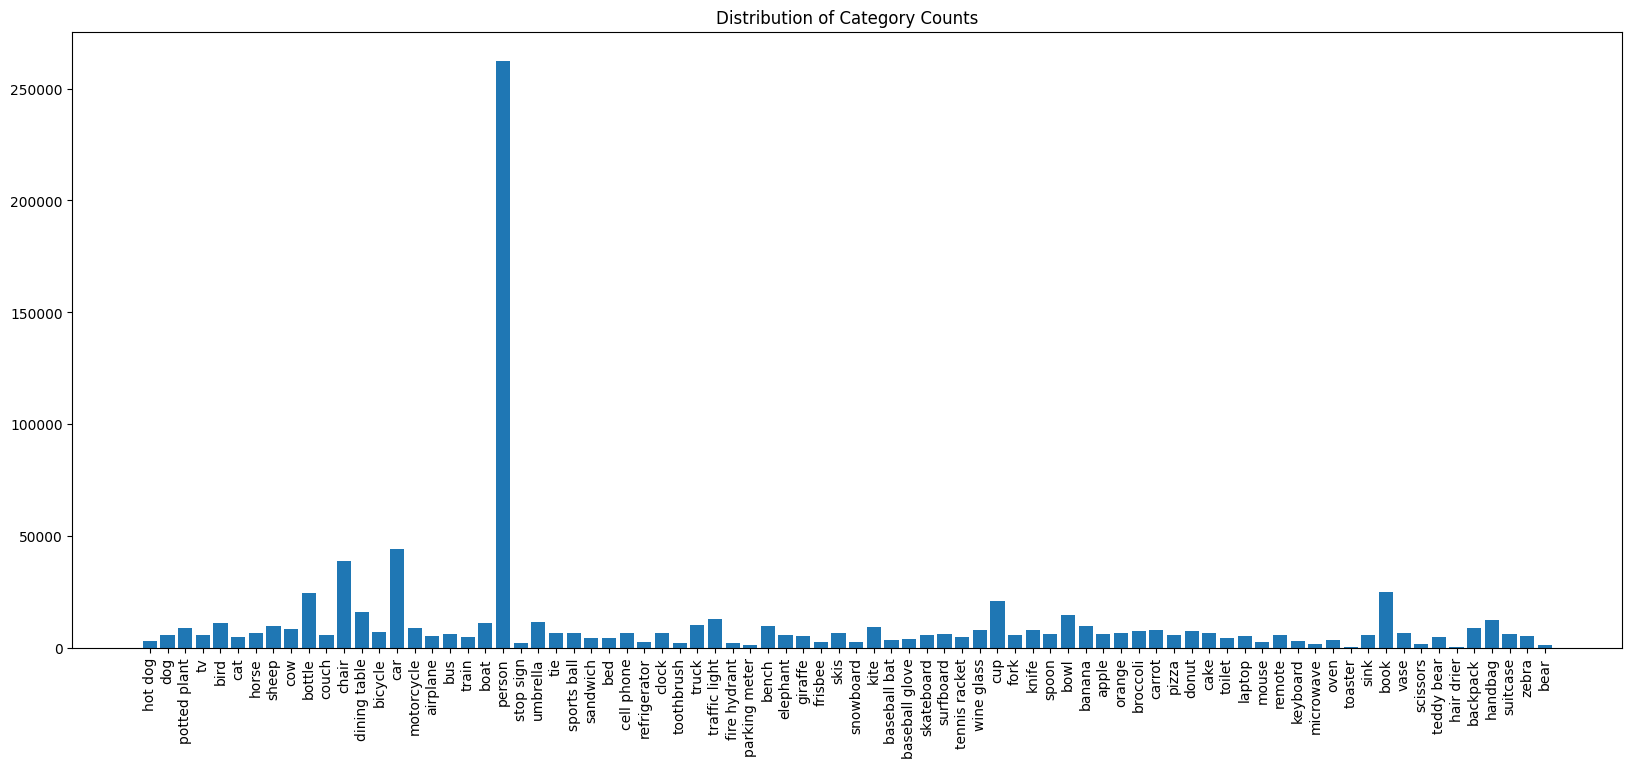

In [18]:
id_to_name = {c["id"]: c["name"] for c in data["categories"]}

for cid, count in sorted(category_counts.items()):
    print(f"{cid} ({id_to_name[cid]}): {count} samples")

names = [id_to_name[cid] for cid in category_counts.keys()]
counts = [category_counts[cid] for cid in category_counts.keys()]

plt.figure(figsize=(20,8))
plt.bar(names, counts)
plt.xticks(rotation=90)
plt.title("Distribution of Category Counts")
plt.show()


In [19]:
for i in range(3):
  print(train_pairs_detection[i])
  print(val_pairs_detection[i])

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
{'img': './data/coco2017/images/val2017/val2017/000000289343.jpg', 'boxes': [[473.07, 395.93, 38.65, 28.67], [204.01, 235.08, 60.84, 177.36], [0.43, 499.79, 339.79, 106.45], [204.42, 304.1, 52.51, 152.76]], 'labels': [18, 1, 15, 2]}
{'img': './data/coco2017/images/train2017_subset/000000200365.jpg', 'boxes': [[234.22, 317.11, 149.39, 38.55], [239.48, 347.87, 160.0, 57.81], [296.65, 388.33, 1.03, 0.0], [251.87, 333.42, 125.94, 22.71], [128.24, 192.99, 511.76, 281.33], [0.0, 36.05, 562.4, 443.74], [131.1, 0.0, 508.9, 24

In [20]:
# type
sample= train_pairs_detection[0]

print("img_path: ", type(sample))
# print("bbox: ", type(sample[1]), "len: ", len(sample[1]))
# print("category: ", type(sample[2]))

img_path:  <class 'dict'>


### 1. Segmenting & extract manual features

In [21]:
from imutils.object_detection import non_max_suppression
from sklearn.preprocessing import StandardScaler

In [22]:
# 1. region proposal (batasi search kumpulan bounding boxes sblm extract feature)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def propose_regions(img):
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  rects = ss.process() #x,y,w,h
  boxes=[]

  for(x,y,w,h) in rects:
    boxes.append([x,y,x+w,y+h])
  return np.array(boxes, dtype=np.float32)

In [23]:
print(type(train_pairs_detection))
print(list(train_pairs_detection[:10]))


<class 'list'>
[{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}, {'img': './data/coco2017/images/train2017_subset/000000200365.jpg', 'boxes': [[234.22, 317.11, 149.39, 38.55], [239.48, 347.87, 160.0, 57.81], [296.65, 388.33, 1.03, 0.0], [251.87, 333.42, 125.94, 22.71], [128.24, 192.99, 511.76, 281.33], [0.0, 36.05, 562.4, 443.74], [131.1, 0.0, 508.9, 248.77], [1.08, 1.08, 130.81, 57.3], [463.29, 202.06, 99.47, 170.41]], 'labels': [58, 58, 58, 58, 67, 2, 3, 3, 47]}, {'img': './data/coco2017/images/train2017_subset/000000495357.jpg', 'boxes': [[337.02, 244.46, 66.47,

image ./data/coco2017/images/train2017_subset/000000558840.jpg -- 11 box


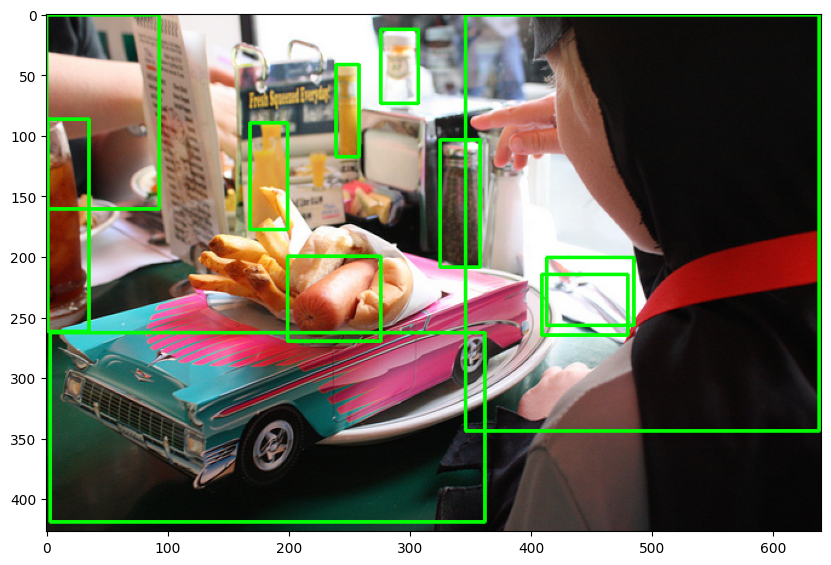

image ./data/coco2017/images/train2017_subset/000000200365.jpg -- 9 box


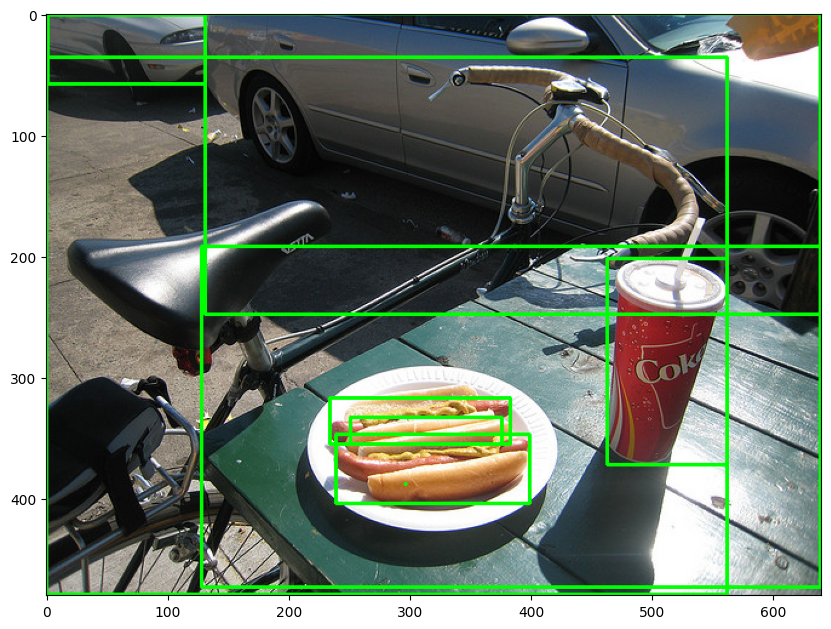

image ./data/coco2017/images/train2017_subset/000000495357.jpg -- 18 box


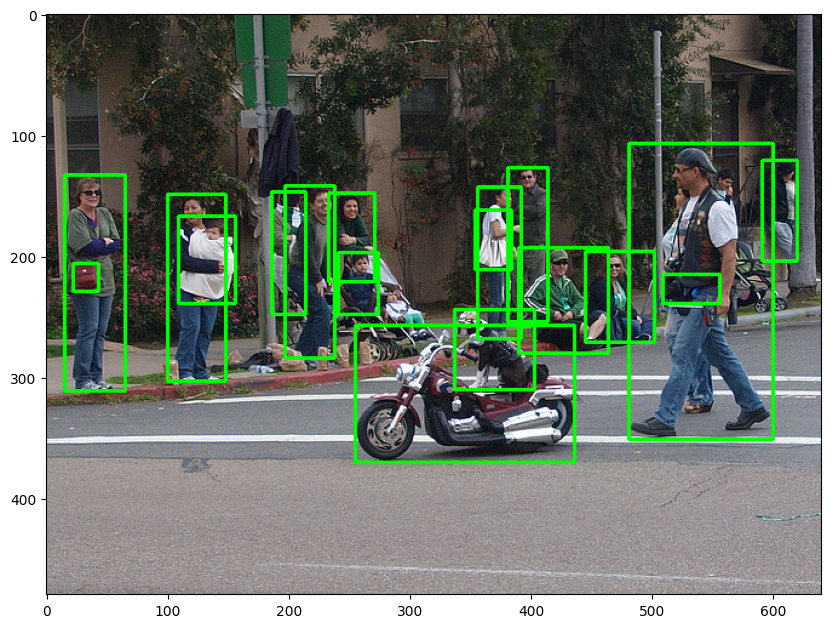

image ./data/coco2017/images/train2017_subset/000000116061.jpg -- 22 box


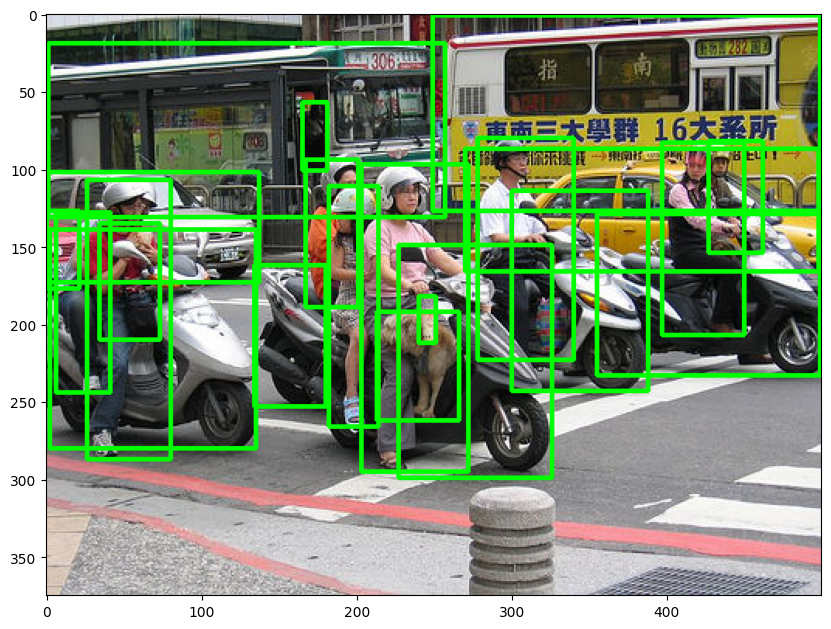

image ./data/coco2017/images/train2017_subset/000000016164.jpg -- 2 box


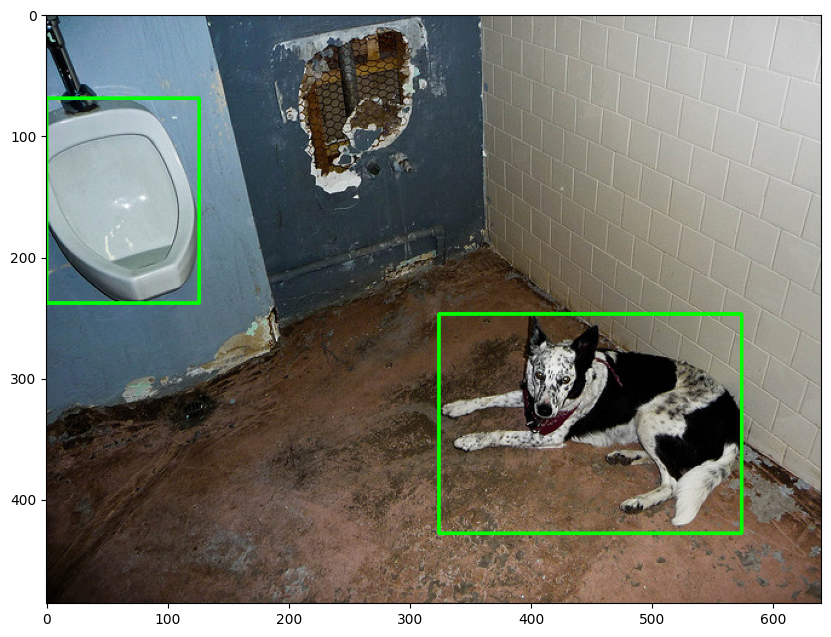

In [24]:
def draw_boxes_img(img_path, boxes_data):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for box in boxes_data:
    # input = x,y,w,h
    x,y,w,h = map(int, box)
    x1,y1 = x,y
    x2,y2 = x+w, y+h

    # rectangle :img, titik awal(x1,y1), akhir(x2,y2), color, tebalny
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.show()

for i in range(5):
  data_item = train_pairs_detection[i]
  print(f"image {data_item['img']} -- {len(data_item['boxes'])} box")
  draw_boxes_img(data_item['img'], data_item['boxes'])
# data_item = train_pairs_detection[0]
# draw_boxes_img(data_item['img'], data_item['boxes'])

In [25]:
def extract_global_sift(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT_create()

  keypoints, descriptors = sift.detectAndCompute(gray, None)

  if descriptors is None:
    # tdk ada fitur / polos
    descriptors = np.zeros((1,128), dtype=np.float32)
  # rata-rata descriptor semua keypoint
  global_feature = np.mean(descriptors, axis=0, dtype=np.float32)
  return global_feature

def extract_region_sift(img, regions, max_regions=20):
  # img, region proposal, max jml boxes
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  sift = cv2.SIFT_create()

  region_features=[]
  valid_boxes=[]

  for(x1,y1,x2,y2) in regions[:max_regions]: #dlm proposal
    # pastikn koordinat valid & dlm batas gambar
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    if x2 <= x1 or y2 <= y1:
      continue  # skip box kosong

    #w,h >0
    crop = img[y1:y2, x1:x2] #crop sesuai region propo
    if crop.size==0:
      continue
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray_crop_enhanced= clahe.apply(gray_crop)

    kp, desc = sift.detectAndCompute(gray_crop_enhanced, None)
    # ekstrak kp, desc dr region propo(yg di crop)

    if desc is None:
      desc_mean = np.zeros((128,), dtype=np.float32) #placeholder
    else:
      desc_mean = np.mean(desc, axis=0)

    region_features.append(desc_mean) #rata-rata desc
    valid_boxes.append([x1,y1,x2,y2])

  # matrix fitur tiap region, list boxes tdk kosong
  return np.array(region_features, dtype=np.float32), np.array(valid_boxes, dtype=np.int32)

In [26]:
dummy_img = np.zeros((500, 500, 3), dtype=np.uint8) # Gambar hitam 500x500
dummy_regions = [
    (10, 10, 100, 100),
    (200, 200, 350, 350),
    (400, 400, 450, 450),
    (1, 1, 5, 5) # Area sgt kecil
]

features_output, valid_regions_output = extract_region_sift(
    dummy_img,
    dummy_regions,
    max_regions=4
)

print(f"Jumlah total wilayah input: {len(dummy_regions)}")
print(f"Jumlah wilayah yang berhasil diproses: {len(valid_regions_output)}")
print("-" * 30)

print(f"Tipe data features_output: {features_output.dtype}")
print(f"Shape/Dimensi features_output: {features_output.shape}")

print(f"Tipe data valid_regions_output: {valid_regions_output.dtype}")
print(f"Shape/Dimensi valid_regions_output: {valid_regions_output.shape}")
print("-" * 30)

Jumlah total wilayah input: 4
Jumlah wilayah yang berhasil diproses: 4
------------------------------
Tipe data features_output: float32
Shape/Dimensi features_output: (4, 128)
Tipe data valid_regions_output: int32
Shape/Dimensi valid_regions_output: (4, 4)
------------------------------


In [27]:
# NORMALIZE FEATURE
def normalize_sift_feat(global_feat, region_feat):
  # l2 norm glob & reg
  l2 = Normalizer(norm='l2')
  global_feat_norm = l2.fit_transform(global_feat)
  region_feat_norm = l2.fit_transform(region_feat)

  return global_feat_norm, region_feat_norm

In [28]:
def extract_manual_features(img_path):
  img = cv2.imread(img_path)
  if img is None:
    print("FAILED read {img_path}")
    return np.zeros((49,128)), np.zeros((20,128)), np.zeros((20,4))

  img = cv2.resize(img, (256,256))
  img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #visualisasi

  global_feat = extract_global_sift(img)
  regions = propose_regions(img)
  region_feat, boxes = extract_region_sift(img,regions,max_regions=20)

  # format global desc spy kompatibel
  # global_feat = np.tile(global_feat, (49,1))

  # normalisasi - stlh build vocab
  # global_feat, region_feat = normalize_sift_feat(global_feat, region_feat)

  return global_feat, region_feat, boxes

In [29]:
path = train_pairs_detection[0]["img"]

g, r, b = extract_manual_features(path)
print("Global shape :", g.shape)
print("Region shape :", r.shape)


print(np.mean(r), np.std(r), np.min(r), np.max(r))

Global shape : (128,)
Region shape : (20, 128)
24.86916 24.66336 0.0 164.42857


#### test check feature shape

In [30]:
# check extract soft global
img_path = train_pairs_detection[0]["img"]
img = cv2.imread(img_path)
global_feat = extract_global_sift(img)
print("Global SIFT feature shape:", global_feat.shape)
print(global_feat[:10])  # lihat 10 nilai pertama

Global SIFT feature shape: (128,)
[25.538523  21.34827   22.738995  21.911163  24.01415   13.6855345
 11.53695   13.7979555 57.892296  34.32626  ]


In [31]:
global_features, region_features, reg_boxes = extract_manual_features(img_path)

print("Global features shape:", global_features.shape)   # (49,128)
print("Region features shape:", region_features.shape)   # (20, 128)
print("Boxes: ", reg_boxes.shape) # 20,4

print(global_features[:1])

Global features shape: (128,)
Region features shape: (20, 128)
Boxes:  (20, 4)
[23.44186]
